In [1]:
# Physics 411 Assignment #5 notebook for questions 1,2

# import libraries

import numpy as np
import random as rn
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
import scipy as sp
from scipy.stats import norm
import datetime 
import matplotlib.dates as mdates
import random
import matplotlib.ticker as plticker
from scipy import signal
from scipy.stats.distributions import chi2
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from numpy.polynomial import Polynomial

### Question 1. Power within diurnal frequency band
1. Read in the hour-resolution temperature data for the Station “UVicSCI ” (48.462oN, 236.691oE).
   Consider two data segments:
      * i) data from 15 November 2019 to 15 February 2020, only
      * ii) data from 1 June 2021 to 1 September 2021, only. For both records do the following:
        (Please include your code.)
          * a) Calculate the total variance of the temperature records.
          *  b) In the time domain, calculate the variance associated with the diurnal cycle, only: Use a
              combination of an elliptic high-pass and an elliptic low-pass filter (i.e. using a high-pass
              and low-pass filter successively) to extract the diurnal frequency band. Convince yourself
              that the filters are well-behaved and that the combination in fact gives the expected
              frequency response.
          * c) In the frequency domain, calculate the variance associated with the diurnal cycle, only.
          * d) Summarize what percentage of variance is included in the diurnal signal? What can
             you say about the dominant time scales of local temperature fluctuations in winter vs.
             summer?

In [2]:
# first we need to read in the correct hourly temperature data:

hourly_temp =np.loadtxt("/Users/benrasmussen/Documents/Phys 411/Data/UVic_weatherdata_temperature_hourly.dat").T

time = hourly_temp[0]
uvic_ht = hourly_temp[14]

# clean up header
uvic_ht = uvic_ht[3:]
time = time[3:]

In [3]:
# finds the range of data for the requisite dates:

time_2_15nov19 = 437160 # hrs
time_2_15feb20 = 439368 # hrs
time_2_1jun21 = 450696 # hrs
time_2_1sept21 = 452904 # hrs

initial_time = 16801 * 24 # hrs
length_of_dayh = 24 # hrs
UTC_change = 7 # hrs

length_w = time_2_15feb20 - time_2_15nov19
length_s = time_2_1sept21 - time_2_1jun21

diff_15nov19 = (time_2_15nov19 - initial_time)
diff_1jun21 = (time_2_1jun21 - initial_time)

# final data sets:

uvic_htw = uvic_ht[diff_15nov19:diff_15nov19 + length_w]
uvic_hts = uvic_ht[diff_1jun21:diff_1jun21 + length_s]

time_w = time[diff_15nov19:diff_15nov19 + length_w]
time_s = time[diff_1jun21:diff_1jun21 + length_s]

time_plw = time_w + initial_time/24
time_pls = time_s + initial_time/24

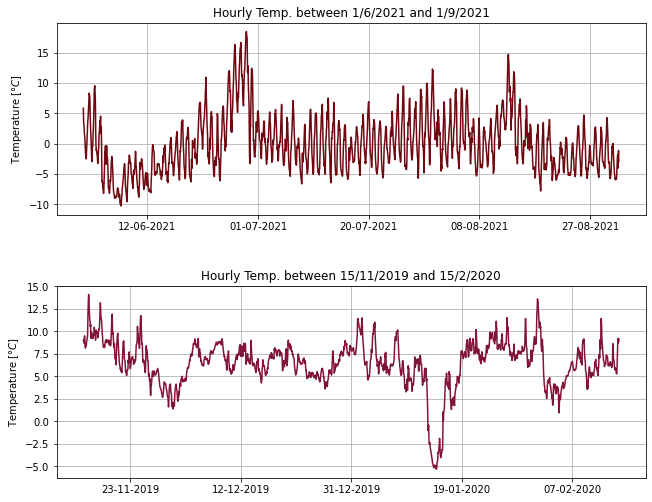

In [4]:
# now want to plot the time series to see if all of the ducks are in a row:

# zero mean data sets:

# means: (using nanmean as some values in this range may not be numbers)

mtw = np.nanmean(uvic_htw); mts = np.nanmean(uvic_hts)

uvic_ztw = (uvic_htw - mtw); uvic_zts = (uvic_hts - mts)

# plots the time series to ensure correct data:

width=10
height=8
ff, (ax2,ax1) = plt.subplots(2,1)
ff.set_figwidth(width)
ff.set_figheight(8)
ff.tight_layout(pad=5.0)

# plots the hourly temp data in winter:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=19))
ax1.plot(time_plw, uvic_htw, color="#82143c")
ax1.set_title("Hourly Temp. between 15/11/2019 and 15/2/2020")
ax1.set_ylabel(r"Temperature [$\degree C$]" )
ax1.grid(True)


# plots the hourly temp data in summer:
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=19))
ax2.plot(time_pls, uvic_zts, color='#6f0810')
ax2.set_title("Hourly Temp. between 1/6/2021 and 1/9/2021")
ax2.set_ylabel(r"Temperature [$\degree C$]" )
ax2.grid(True)




In [5]:
# we now want to find the variance associated with the entire
# data set for both seasosn:

# variances:
uvic_tsvar = np.var(uvic_zts)
uvic_twvar = np.var(uvic_ztw)

print(f"The variance associated with the summer data is: {uvic_tsvar:0.3f} C^2")
print(f"The variance associated with the winter data is: {uvic_twvar:0.3f} C^2")


The variance associated with the summer data is: 22.219 C^2
The variance associated with the winter data is: 7.054 C^2


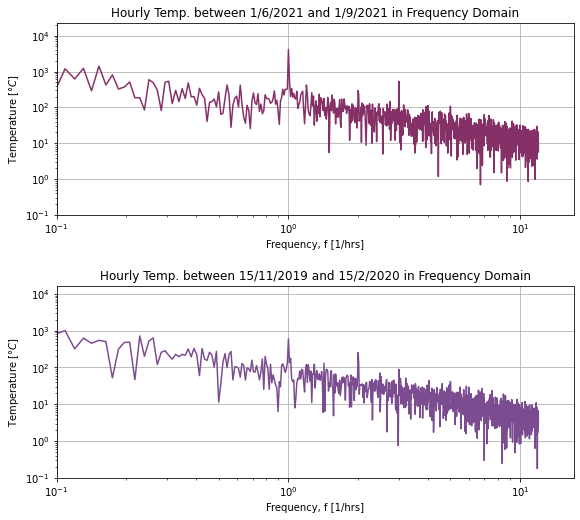

In [6]:
# we now want to apply an elliptic band pass filter to extract the 
# diurnal frequency:

# we begin by taking fourier transform of the signals and plotting:

uvic_ts_ft = np.fft.fft(uvic_zts); uvic_ts_freqs = np.fft.fftfreq(len(uvic_zts), 1/24)
uvic_tw_ft = np.fft.fft(uvic_ztw); uvic_tw_freqs = np.fft.fftfreq(len(uvic_ztw), 1/24)

# plots the time series in the frequency domain:

width=9
height=8
ff, (ax2,ax1) = plt.subplots(2,1)
ff.set_figwidth(width)
ff.set_figheight(8)
ff.tight_layout(pad=5.0)

# plots the hourly temp data in winter in frequency space:
ax1.loglog(uvic_tw_freqs[:1104], np.abs(uvic_tw_ft[:1104]), color='#7b4d90')
ax1.set_title("Hourly Temp. between 15/11/2019 and 15/2/2020 in Frequency Domain")
ax1.set_ylabel(r"Temperature [$\degree C$]" )
ax1.set_xlabel("Frequency, f [1/hrs]")
ax1.grid(True)
ax1.set_ylim(1e-1)
ax1.set_xlim(1e-1)


# plots the hourly temp data in summer in frequency space:
ax2.loglog(uvic_ts_freqs[:1104], np.abs(uvic_ts_ft[:1104]), color='#863068')
ax2.set_title("Hourly Temp. between 1/6/2021 and 1/9/2021 in Frequency Domain")
ax2.set_xlabel("Frequency, f [1/hrs]")
ax2.set_ylabel(r"Temperature [$\degree C$]" )
ax2.set_ylim(1e-1)
ax2.set_xlim(1e-1)
ax2.grid(True)


In [7]:
# we now want to use subsequent elliptic filters to create an elliptic 
# bandpass to extract the diurnal frequency:

# low pass elliptic:

order = 5 # filter order
max_rip = 0.5 # maximum ripple in dB
min_rip = 40 # minimum ripple in dB
fsamp = 24

# critical frequencies:

crit_f = [0.94, 0.97] 

# filter polynomials:

b_low, a_low = signal.iirfilter(order, Wn=crit_f[1], rp=max_rip, rs=min_rip, btype='lowpass', ftype='ellip',fs=fsamp/4)
b_high, a_high = signal.iirfilter(order, Wn=crit_f[0], rp=max_rip, rs=min_rip, btype='highpass', ftype='ellip',fs=fsamp/4)

# filters as sos:

sos_low = signal.iirfilter(order, Wn=crit_f[1], rp=max_rip, rs=min_rip, btype='lowpass', ftype='ellip',fs=fsamp, output='sos')
sos_high = signal.iirfilter(order, Wn=crit_f[0], rp=max_rip, rs=min_rip, btype='highpass', ftype='ellip',fs=fsamp, output='sos')

# frequencies to plot the filters:

freq_low, f_resp_low = signal.freqz(b_low,a_low)
freq_high, f_resp_high = signal.freqz(b_high,a_high)





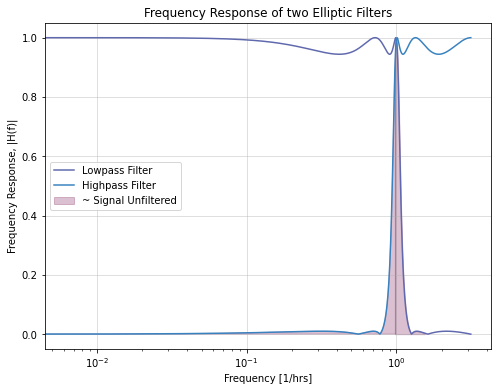

In [8]:
# plots both filters in the frequency domain:

width=8
height=6
ff, (ax1) = plt.subplots(1,1)
ff.set_figwidth(width)
ff.set_figheight(height)

ax1.semilogx(freq_low, abs(f_resp_low), color='#6069ae', label="Lowpass Filter")
ax1.semilogx(freq_high, abs(f_resp_high), color='#3982c0', label="Highpass Filter")
#ax1.semilogx(uvic_ts_freqs[:1104], np.abs(uvic_ts_ft[:1104])/4000, color='#863068')
#ax1.semilogx(uvic_tw_freqs[:1104], np.abs(uvic_tw_ft[:1104])/4000, color='#7b4d90')
ax1.fill_between(x=freq_low, y1=abs(f_resp_high), where=(-0.75 <freq_low)&(freq_low<1.0), color='#863068', alpha=0.3, label="~ Signal Unfiltered")
ax1.fill_between(x=freq_low, y1=abs(f_resp_low), where=(0.97 <freq_low)&(freq_low<1.55), color='#863068', alpha=0.3)

ax1.set_title("Frequency Response of two Elliptic Filters")
ax1.set_ylabel(r"Frequency Response, |H(f)|")
ax1.set_xlabel("Frequency [1/hrs]")
ax1.legend()
ax1.grid(True, alpha=0.5)


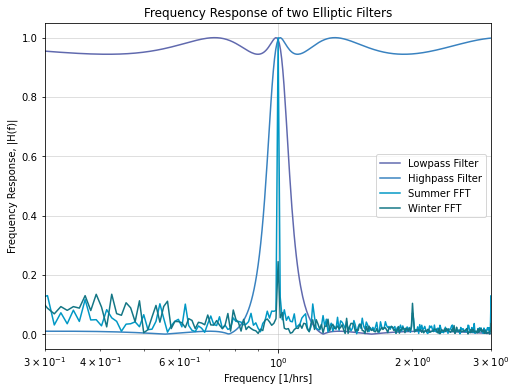

In [9]:
# plots the filters with respect to a normalized spectrum of the 
# temperature data in the frequency domain:

# maximums:

max_s = max(np.abs(uvic_ts_ft[:1104]))
max_w = max(np.abs(uvic_tw_ft[:1104]))

width=8
height=6
ff, (ax1) = plt.subplots(1,1)
ff.set_figwidth(width)
ff.set_figheight(height)

ax1.semilogx(freq_low, abs(f_resp_low), color='#6069ae', label="Lowpass Filter")
ax1.semilogx(freq_high, abs(f_resp_high), color='#3982c0', label="Highpass Filter")
ax1.semilogx(uvic_ts_freqs[:1104], np.abs(uvic_ts_ft[:1104])/max_s, color='#0198c5', label="Summer FFT")
ax1.semilogx(uvic_tw_freqs[:1104], np.abs(uvic_tw_ft[:1104])/max_w, color='#137685', label="Winter FFT")

ax1.set_title("Frequency Response of two Elliptic Filters")
ax1.set_ylabel(r"Frequency Response, |H(f)|")
ax1.set_xlabel("Frequency [1/hrs]")
ax1.legend()
ax1.set_xlim(0.3, 3)
ax1.grid(True, alpha=0.5)

In [10]:
# using both of our filters, we now need to apply them to the original 
# signals:

# applies low pass filter:

uvic_ts_filt_int = signal.sosfilt(sos_low, uvic_zts)
uvic_tw_filt_int = signal.sosfilt(sos_low, uvic_ztw)

# applies high pass filter:

uvic_ts_filt = signal.sosfilt(sos_high, uvic_ts_filt_int)
uvic_tw_filt = signal.sosfilt(sos_high, uvic_tw_filt_int)



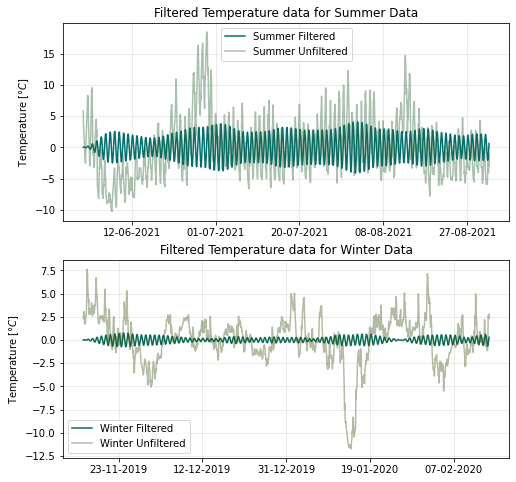

In [11]:
# plotting the above function in the range -1<t<1 with original overlayed:

ff, (ax1,ax2) = plt.subplots(2, 1)
ff.set_figwidth(8)
ff.set_figheight(8)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=19))
ax1.plot(time_pls, uvic_ts_filt, color='#00716f', label="Summer Filtered")
ax1.plot(time_pls, uvic_zts, color='#2c6336', alpha=0.4, label="Summer Unfiltered")

ax1.set_title("Filtered Temperature data for Summer Data")
ax1.set_ylabel(r"Temperature [$\degree C$]" )
ax1.legend()
ax1.grid(True, alpha=0.3)
#ax1.set_xlim(18839,18840)

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=19))
ax2.plot(time_plw, uvic_tw_filt, color='#0d6b54', label="Winter Filtered")
ax2.plot(time_plw, uvic_ztw, color='#41591a', alpha=0.4, label="Winter Unfiltered")

ax2.set_title("Filtered Temperature data for Winter Data")
ax2.set_ylabel(r"Temperature [$\degree C$]" )
ax2.legend()
ax2.grid(True, alpha=0.3)

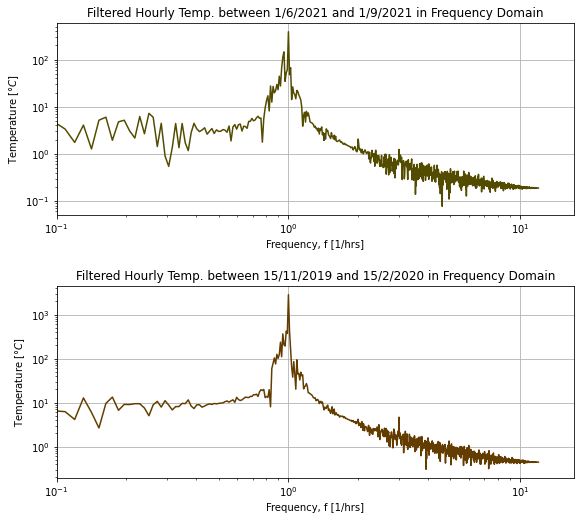

In [12]:
# we can now  take the fft of this signal again to check if everything is well behaved:

uvic_ts_ft_filt = np.fft.fft(uvic_ts_filt); uvic_ts_f_filt = np.fft.fftfreq(len(uvic_ts_filt), 1/24)
uvic_tw_ft_filt = np.fft.fft(uvic_tw_filt); uvic_tw_f_filt = np.fft.fftfreq(len(uvic_ts_filt), 1/24)

# plots the time series in the frequency domain:

width=9
height=8
ff, (ax2,ax1) = plt.subplots(2,1)
ff.set_figwidth(width)
ff.set_figheight(8)
ff.tight_layout(pad=5.0)

# plots the hourly temp data in winter in frequency space:
ax1.loglog(uvic_ts_f_filt[:1104], np.abs(uvic_ts_ft_filt[:1104]), color='#633d00')
ax1.set_title("Filtered Hourly Temp. between 15/11/2019 and 15/2/2020 in Frequency Domain")
ax1.set_ylabel(r"Temperature [$\degree C$]" )
ax1.set_xlabel("Frequency, f [1/hrs]")
ax1.grid(True)
#ax1.set_ylim(1e-1)
ax1.set_xlim(1e-1)


# plots the hourly temp data in summer in frequency space:
ax2.loglog(uvic_tw_f_filt[:1104], np.abs(uvic_tw_ft_filt[:1104]), color='#534c00')
ax2.set_title("Filtered Hourly Temp. between 1/6/2021 and 1/9/2021 in Frequency Domain")
ax2.set_xlabel("Frequency, f [1/hrs]")
ax2.set_ylabel(r"Temperature [$\degree C$]" )
#ax2.set_ylim(1e-1)
ax2.set_xlim(1e-1)
ax2.grid(True)


In [13]:
# we can now find the variance after having filtered out everything but the diurnal band:

# variances:
uvic_tsvar_filt = np.var(uvic_ts_filt)
uvic_twvar_filt = np.var(uvic_tw_filt)

print(f"The variance associated with the summer data is: {uvic_tsvar_filt:0.3f} C^2")
print(f"The variance associated with the winter data is: {uvic_twvar_filt:0.3f} C^2")



The variance associated with the summer data is: 3.679 C^2
The variance associated with the winter data is: 0.089 C^2


Just as variance is defined for discrete time series in time domain, we can use the following relation to find it in the frequency domain. In doing so, hoever, we need to find the power spectral density of the signal and as such will use the methods used in assignment 4 once again:

$$
\frac{1}{N} \sum_{r=-n}^{n-1} s_r^2 = \frac{1}{2\pi}\sum_{m=-n}^{n-1} |S_m|^2 = \sigma_x^2
$$

In [14]:
# we now need to find the variance associated with the frequency domain signal, 
# will do this using the parameters from assignment 4 and the welch method:

nfft = 2**8 # length of points in each window  
window = "hann"  # python argument for hanning window
overlap = nfft / 2 # will give an overlap of 50% of the windows points
fsamp = 24 # samples per day

# power spectra:

freq_hts, pxx_hts = signal.welch(uvic_ts_filt, fs=fsamp, window=window, nperseg=nfft, noverlap=overlap)
freq_htw, pxx_htw = signal.welch(uvic_tw_filt, fs=fsamp, window=window, nperseg=nfft, noverlap=overlap)

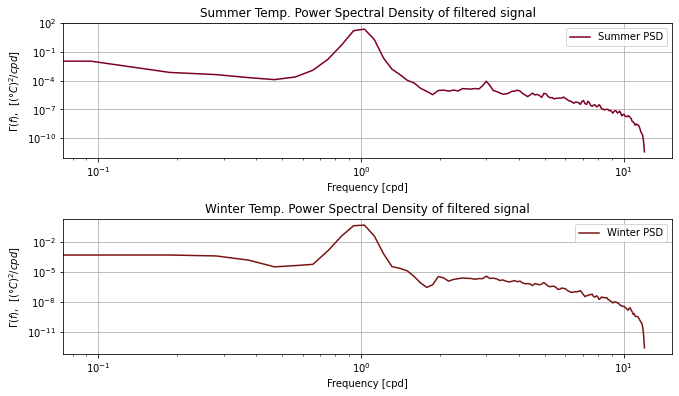

In [15]:
# plots the two power spectral densities:

width=10
height=6
ff, (ax2,ax1) = plt.subplots(2,1)
ff.set_figwidth(width)
ff.set_figheight(height)
ff.tight_layout(pad=4.0)


ax1.loglog(freq_htw, pxx_htw, color='#771411', label="Winter PSD")
ax1.set_title("Winter Temp. Power Spectral Density of filtered signal")
ax1.set_ylabel(r"$\Gamma(f)$,  $ [(\degree C)^2/cpd]$")
ax1.set_xlabel("Frequency [cpd]")
ax1.legend()
ax1.grid(True)


ax2.loglog(freq_hts, pxx_hts, color='#7c001f', label="Summer PSD")
ax2.set_title("Summer Temp. Power Spectral Density of filtered signal")
ax2.set_ylabel(r"$\Gamma(f)$,  $ [(\degree C)^2/cpd]$")
ax2.set_xlabel("Frequency [cpd]")
ax2.legend()
ax2.grid(True)

In [16]:
# we can now find the variance associated with this signal of only the diurnal band:

# the sum of the spectra in the frequency domain:

psd_sum_tw = sum(abs(np.array(pxx_htw)))/(2*np.pi)
psd_sum_ts = sum(abs(np.array(pxx_hts)))/(2*np.pi)

print(f"The variance associated with the summer data in frequency domain is: {psd_sum_ts:0.3f} C^2")
print()
print(f"The variance associated with the winter data in frequency domain is: {psd_sum_tw:0.3f} C^2")

The variance associated with the summer data in frequency domain is: 6.551 C^2

The variance associated with the winter data in frequency domain is: 0.153 C^2


In [17]:
# variance percentages in diurnal signal:

td_var_per_ts = uvic_tsvar_filt/uvic_tsvar * 100
td_var_per_tw = uvic_twvar_filt/uvic_twvar * 100

fd_var_per_ts = psd_sum_ts/uvic_tsvar * 100
fd_var_per_tw = psd_sum_tw/uvic_tsvar * 100

print(f"The Range in variance percentages associated with the summer data diurnal signal is [TD,FD]: {td_var_per_ts:.3f}% < Var[T_s] < {fd_var_per_ts:.3f}%")
print()
print(f"The Range in variance percentages associated with the winter data diurnal signal is [FD,TD]: {fd_var_per_tw:.3f}% < Var[T_w] < {td_var_per_tw:.3f}%")

The Range in variance percentages associated with the summer data diurnal signal is [TD,FD]: 16.557% < Var[T_s] < 29.483%

The Range in variance percentages associated with the winter data diurnal signal is [FD,TD]: 0.689% < Var[T_w] < 1.265%


We can clearly see from the above that the summer diurnal period has a significantly larger percentage of the signals total variance associated with it when compared to the winter data. Since we have that $\sigma^2_x \propto power$ of the diurnal signal band, we can conclude that there exists much more energy at the daily cycle in the summer than in the winter. We can then say that the dominant time scale for local temperature fluctuations in the summer is ~daily while for the winter, the dominant time scales lie elsewhere. By looking at the FFT for both data sets this roughly makes sense are there is more amplitude in harmonic frequencies and frequencies < $f_{diurnal}$ in the winter data.

### Question 2. Spatial gridding
1. For each station calculate the average temperatures for 29 June 2021 and 29 June 2022 from
   the hour-resolution temperature data. Averages should be calculated for local time (00:00 -
   23:00 PDT.)
   
    The goal is to generate spatially interpolated maps of these mean temperature fields using
    gridding methods discussed in class. All maps should use 50 grid cells in the N-S direction
   and 30 grid cells in the E-W direction, and should be displayed as filled contour maps
    (contourf.m or matplotlib.pyplot.contourf ). Include the station locations on the maps.
    Please include your code.
     * a) Use a global interpolation with 1/r2 weighting.
     * b) Use a local gridding with ‘Natural neighbour interpolation’. You may want to use built-in
       functions ‘griddata.m’ or ‘scipy.interpolate.griddata’. 
     * c) Briefly discuss the results of the two gridding methods.
     * d) Replot the gridded data from a) and b) on a pseudo-colour checkerboard (pcolor.m or
       matplotlib.pyplot.pcolor ). Add colorbars to the plots.

In [18]:
# first we need to read in the correct hourly temperature data:

hourly_col =np.loadtxt("/Users/benrasmussen/Documents/Phys 411/Data/UVic_weatherdata_temperature_hourly.dat")
hourly_temp =np.loadtxt("/Users/benrasmussen/Documents/Phys 411/Data/UVic_weatherdata_temperature_hourly.dat").T

time = hourly_temp[0]

# clean up header

time = time[3:]

# station data with headers removed:

bowser = hourly_temp[1][3:]; cortes = hourly_temp[2][3:]; craigflower = hourly_temp[3][3:];
cumberland = hourly_temp[4][3:]; happyvalley = hourly_temp[5][3:]; jamesbay = hourly_temp[6][3:];
macauley = hourly_temp[7][3:]; monterey = hourly_temp[8][3:]; phoenix = hourly_temp[9][3:]
rvyc = hourly_temp[10][3:]; rogers = hourly_temp[11][3:]; shawniganlake = hourly_temp[12][3:]
strawberry = hourly_temp[13][3:]; uvicsci = hourly_temp[14][3:]; viu = hourly_temp[15][3:]

all_temps = [bowser,cortes,craigflower,cumberland,happyvalley,
                jamesbay,macauley,monterey,phoenix,rvyc,rogers,
                shawniganlake,strawberry,uvicsci,viu]

# coordinates:

longitude = hourly_col[0][1:]
latitude = hourly_col[1][1:]
elevation = hourly_col[2][1:]


In [19]:
# now need to find temps for just june 29 2021 -> june 29 2022:

time_2_29jun21 = 451368 # hrs
time_2_29jun22 = 460128 # hrs

initial_time = 16801 * 24 # hrs
length_of_dayh = 24 # hrs
UTC_change = 7 # hrs

length_int = time_2_29jun22 - time_2_29jun21

diff_29jun21 = time_2_29jun21 - initial_time + UTC_change

# time:

time_plot = time[diff_29jun21:diff_29jun21 + length_int] + initial_time/24

temperatures = [station[diff_29jun21:diff_29jun21 + length_int] for station in all_temps]

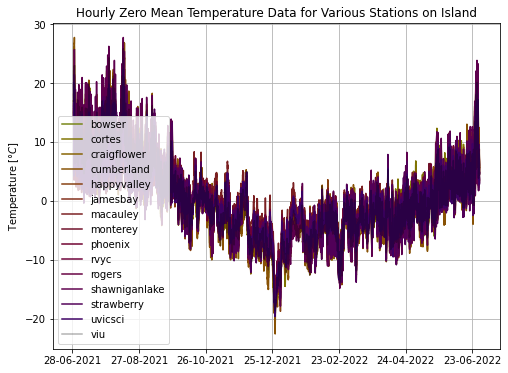

In [20]:
# now we can plot the zero mean of each data set to ensure everything is in order:

mean_temps = [np.nanmean(station) for station in temperatures]

zm_temps = []
for idx, station in enumerate(temperatures):
    zm_temperature = station - mean_temps[idx]
    zm_temps.append(zm_temperature)

fig, (ax1) = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)

labels=['bowser','cortes','craigflower','cumberland','happyvalley',
                'jamesbay','macauley','monterey','phoenix','rvyc','rogers',
                'shawniganlake','strawberry','uvicsci','viu']
colours=['#778515','#807402', '#866300', '#885205', '#874010', 
         '#822f1a', '#7a1f21', '#6f0e28', '#6e002f', '#6c0038',
         '#670041', '#5e004d', '#510058', '#3d0064', 'k']

# plots the hourly data:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=60))

alph = 0.24
for idx in range(len(zm_temps)):
    alph += 0.05
    if idx != 14:
        ax1.plot(time_plot, zm_temps[idx], label=labels[idx],alpha=1, color=colours[idx])
    else:
        ax1.plot(time_plot, zm_temps[idx], label=labels[idx],alpha=0.3, color=colours[idx])

ax1.legend()
ax1.set_title(r"Hourly Zero Mean Temperature Data for Various Stations on Island")
ax1.set_ylabel(r"Temperature [$\degree C$]" )
ax1.grid(True)


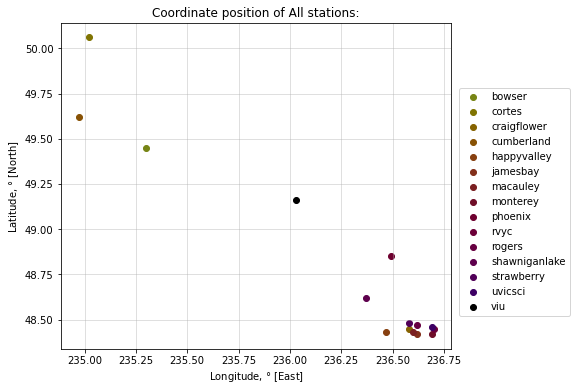

In [21]:
# now we want to plot the coordinates of the stations for completeness:

coordinates = np.array(list(zip(longitude, latitude)))

width=7
height=6
ff, (ax1) = plt.subplots(1,1)
ff.set_figwidth(width)
ff.set_figheight(height)

for idx in range(len(coordinates[:,0])):
    ax1.scatter(coordinates[:,0][idx], coordinates[:,1][idx], label=labels[idx],color=colours[idx])


ax1.set_title("Coordinate position of All stations:")
ax1.set_xlabel(r"Longitude, $\degree$ [East]")
ax1.set_ylabel(r"Latitude, $\degree$ [North]")
ax1.legend(bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0)
ax1.grid(True, alpha=0.5)

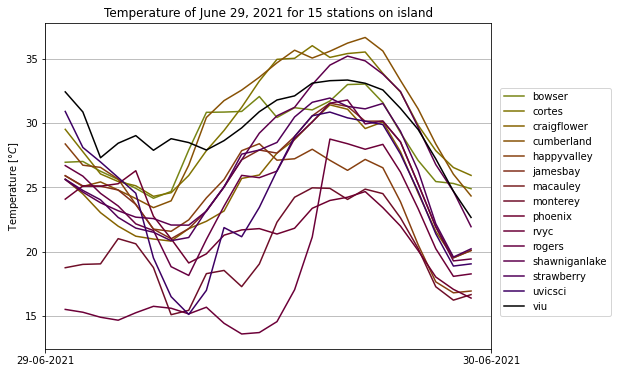

In [22]:
# made a little error and did the entire range of data rather than just,
# the two days:

length_day = 24 # hrs

temp_29jun21 = [temperatures[idx][0:length_day] for idx in range(len(temperatures))]
temp_29jun22 = [temperatures[idx][8736:8736+length_day] for idx in range(len(temperatures))]


# plots the time series:

fig, (ax1) = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)

labels=['bowser','cortes','craigflower','cumberland','happyvalley',
                'jamesbay','macauley','monterey','phoenix','rvyc','rogers',
                'shawniganlake','strawberry','uvicsci','viu']
colours=['#778515','#807402', '#866300', '#885205', '#874010', 
         '#822f1a', '#7a1f21', '#6f0e28', '#6e002f', '#6c0038',
         '#670041', '#5e004d', '#510058', '#3d0064', 'k']

# plots the hourly data:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=60))

alph = 0.24
for idx in range(len(zm_temps)):
    alph += 0.05
    ax1.plot(time_plot[0:24], temp_29jun21[idx], label=labels[idx],alpha=1, color=colours[idx])


ax1.legend(bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0)
ax1.set_title(r"Temperature of June 29, 2021 for 15 stations on island")
ax1.set_ylabel(r"Temperature [$\degree C$]" )
ax1.grid(True)



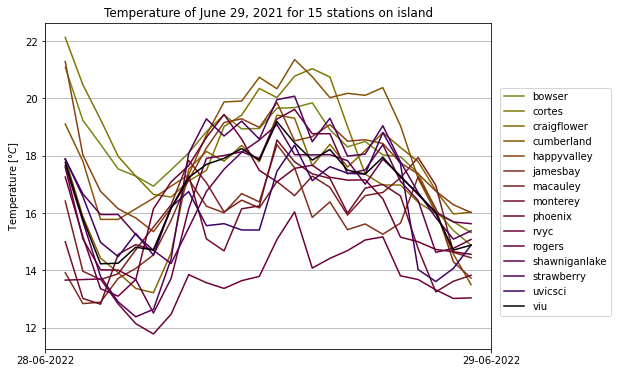

In [23]:
# plots the time series:

fig, (ax1) = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)

labels=['bowser','cortes','craigflower','cumberland','happyvalley',
                'jamesbay','macauley','monterey','phoenix','rvyc','rogers',
                'shawniganlake','strawberry','uvicsci','viu']
colours=['#778515','#807402', '#866300', '#885205', '#874010', 
         '#822f1a', '#7a1f21', '#6f0e28', '#6e002f', '#6c0038',
         '#670041', '#5e004d', '#510058', '#3d0064', 'k']

# plots the hourly data:
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=60))

alph = 0.24
for idx in range(len(zm_temps)):
    alph += 0.05
    ax1.plot(time_plot[8736:8736+length_day], temp_29jun22[idx], label=labels[idx],alpha=1, color=colours[idx])

ax1.legend(bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0)
ax1.set_title(r"Temperature of June 29, 2021 for 15 stations on island")
ax1.set_ylabel(r"Temperature [$\degree C$]" )
ax1.grid(True)


In [24]:
# now need the mean values for both of these time series:

mean_temps_21 = [np.nanmean(station) for station in temp_29jun21]
mean_temps_22 = [np.nanmean(station) for station in temp_29jun22]

# removes the nan value:

mean_temps_21=np.delete(mean_temps_21,6)

# removes latitude and longitude for index 6 value in 2021:

latitude21 = np.delete(latitude, 6)
longitude21 = np.delete(longitude, 6)

/Users/benrasmussen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
# need gridded data with 30 squares in the N-S direction and 50 in the E-W:

buffer =0.2

x_coordinates = np.linspace(min(longitude)-buffer, max(longitude)+buffer,30)
y_coordinates = np.linspace(min(latitude)-buffer, max(latitude)+buffer,50)

# data gridding:

grid_x, grid_y = np.meshgrid(x_coordinates, y_coordinates)



In [28]:
# now need to write a function that does 1/r^2 global interpolation:

def global_interp(grid_x, grid_y, X, Y, Z):
    '''
    Does a global interpolation in the X-Y plane 
    based on a gridded data set with an interpolation 
    scheme with 1/r^2 as the weighting
    
    grid_x = x gridded points to interpolate to
    grid_y = y gridded points to interpolate to
    X = x scattered data points to interpolate from
    Y = y scattered data points to interpolage from
    Z = magnitude of the last variable in X-Y plane
    '''
    
    # finds shape of gridded data and flattens:
    
    shape_of_x = np.shape(grid_x)
    shape_of_y = np.shape(grid_y)
    
    flattened_x = grid_x.flatten()
    flattened_y = grid_y.flatten()
    
    # loops through both our gridded data and magnitude data:
    
    values = []
    
    for xx, yy in zip(flattened_x,flattened_y):
        radial=[]
        for dx,dy in zip(X,Y):
            Dx = dx-xx
            Dy = dy-yy
            # finally 1/r^2
            radial_i = Dx**2 +Dy**2
            radial.append(radial_i)
        
        # weights the interpolation with 1/r^2:
        weighting = (1/np.array(radial))
        total_weight = sum(weighting)
                     
        value = sum(np.multiply(weighting, np.array(Z)))
        value_avg = values / total_weight
        values.append(value_avg)
    
    gridded_values = np.array(values).reshape(shape_of_x)
    
    return gridded_values

In [ ]:
# gridded data:

#global_interp21 = global_interp(grid_x, grid_y, longitude21, latitude21, mean_temps_21)
#global_interp22 = global_interp(grid_x, grid_y, longitude, latitude, mean_temps_22)

